# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

In [21]:
import datetime
import pandas as pd
import seaborn as sns

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
!ls

archive.tar.gz		       Sparkify.ipynb
mini_sparkify_event_data.json  Sparkify-zh.ipynb


In [6]:
data = 'mini_sparkify_event_data.json'
df = spark.read.json(data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [8]:
print(f"there are {df.count()} datapoints")

there are 286500 datapoints


In [9]:
# drop NA values (in userId and sessionId)
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

lookslike there are no `NA` values in `userId` and `sessionId`. But look for empty srtings in  `userId`.

In [10]:
df.groupBy("userId").count().orderBy("userId").show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



there are 8346 user ids having empty string as its id. remove them.

In [11]:
df = df.filter(df.userId != "")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# show schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# type of pages
df.select("page").dropDuplicates().show(10)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
+--------------------+
only showing top 10 rows



In [14]:
# convert time to 24h
fix_time = f.udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0).hour)
df = df.withColumn("time", fix_time(df.ts))

In [15]:
df.filter(df.page == "NextSong").groupby(df.time).count().orderBy(df.time.cast("float")).show(24)

+----+-----+
|time|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
|  20|10856|
|  21|10458|
|  22|10122|
|  23| 9630|
+----+-----+



In [16]:
# account cancellation
churn = f.udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("userChurn", churn("page"))

In [17]:
# downgrade = f.udf(lambda x: 1 if x =="Downgrade" else 0, IntegerType())
# df = df.withColumn("downgrade", downgrade("page"))

In [18]:
date = f.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("date", date("ts"))

In [19]:
df.filter(df.page == 'Cancellation Confirmation').take(1)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', time='20', userChurn=1, date='2018-10-07 20:26:30')]

In [20]:
df.select("userId","gender","userChurn").distinct().groupby(['gender',"userChurn"]).count().show()


+------+---------+-----+
|gender|userChurn|count|
+------+---------+-----+
|     M|        1|   32|
|     F|        0|  104|
|     F|        1|   20|
|     M|        0|  121|
+------+---------+-----+



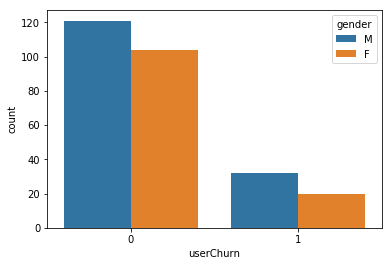

In [22]:
churn_df = df.select("userId","gender","userChurn").distinct().groupby(['gender',"userChurn"]).count().toPandas()
sns.barplot(data=churn_df, x="userChurn", y="count", hue='gender')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

data to be extracted: userId, nSongs, thumsUp, thumbsDown, rollAdvert, genderM, genderF, length, levelFree, levelPaid, userChurn

In [21]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='0', userChurn=0, date='2018-10-01 00:01:57')]

In [22]:
ml_data = df.select("userId").distinct()

In [23]:
n_songs = df.select("userId").filter(df.page == 'NextSong').groupBy("userId").count()
ml_data = ml_data.join(n_songs.withColumnRenamed('count', 'nSongs'),on=["userId"],how="left")
#ml_data.take(1)

In [24]:
thumbs_up = df.select("userId").filter(df.page == 'Thumbs Up').groupBy("userId").count()
thumbs_down = df.select("userId").filter(df.page == 'Thumbs Down').groupBy("userId").count()
ml_data = ml_data.join(thumbs_up.withColumnRenamed('count', 'thumbsUp'),on=["userId"],how="left")
ml_data = ml_data.join(thumbs_down.withColumnRenamed('count', 'thumbsDown'),on=["userId"],how="left")
#ml_data.take(1)

In [25]:
roll_advert = df.select("userId").filter(df.page == 'Roll Advert').groupBy("userId").count()
ml_data = ml_data.join(roll_advert.withColumnRenamed('count', 'rollAdvert'),on=["userId"],how="left")
#ml_data.take(1)

In [26]:
female = df.select("userId","gender").groupby('userId').agg(f.first(f.when(f.col('gender') == "F", 1)).alias("female"))
female = female.na.fill(value=0)
# female.show(5)

ml_data = ml_data.join(female.withColumnRenamed('female', 'genderF'),on=["userId"],how="left")
# ml_data.take(1)

In [27]:
male = df.select("userId","gender").groupby('userId').agg(f.first(f.when(f.col('gender') == "M", 1)).alias("male"))
male = male.na.fill(value=0)
# male.show(5)

ml_data = ml_data.join(male.withColumnRenamed('male', 'genderM'),on=["userId"],how="left")
# ml_data.take(1)

In [28]:
free = df.select("userId","level").groupby('userId').agg(f.first(f.when(f.col('level') == "free", 1)).alias("free"))
free = free.na.fill(value=0)
# free.show(5)

ml_data = ml_data.join(free.withColumnRenamed('free', 'levelFree'),on=["userId"],how="left")
# ml_data.take(1)

In [29]:
paid = df.select("userId","level").groupby('userId').agg(f.first(f.when(f.col('level') == "paid", 1)).alias("paid"))
paid = paid.na.fill(value=0)
# paid.show(5)

ml_data = ml_data.join(paid.withColumnRenamed('paid', 'levelPaid'),on=["userId"],how="left")
# ml_data.take(1)

In [30]:
sessions_length = df.select("userId","sessionId","ts")\
.groupby(['userId','sessionId'])\
.agg(((f.max('ts') - f.min('ts'))/1000)\
.alias('sessionlength'))
avg_session = sessions_length.groupby("userId").agg({"sessionlength": "avg"})
# sessions_length.show(5)

ml_data = ml_data.join(avg_session.withColumnRenamed('avg(sessionlength)', 'avgSessions'),on=["userId"],how="left")
# ml_data.take(1)

In [31]:
churn = df.select("userId").filter(df.page == 'Cancellation Confirmation').groupby("UserId").count()
churn = churn.na.fill(value=0)
# churn.show(5)

ml_data = ml_data.join(churn.withColumnRenamed('count', 'userChurn'),on=["userId"],how="left")
# ml_data.take(1)

In [32]:
ml_data = ml_data.na.fill(value=0)
ml_data.show(5)

+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
|userId|nSongs|thumbsUp|thumbsDown|rollAdvert|genderF|genderM|levelFree|levelPaid|      avgSessions|userChurn|
+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
|100010|   275|      17|         5|        52|      1|      0|        1|        0|           9269.0|        0|
|200002|   387|      21|         6|         7|      0|      1|        1|        0|          15984.0|        0|
|   125|     8|       0|         0|         1|      0|      1|        1|        0|           1774.0|        1|
|    51|  2111|     100|        21|         0|      0|      1|        0|        1|          52341.4|        1|
|   124|  4079|     171|        41|         4|      1|      0|        0|        1|34739.65517241379|        0|
+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
o

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [33]:
# string to numeric conversion
for column in ml_data.columns:
    features = ml_data.withColumn(column, ml_data[column].cast("float"))
    
features.show(5)

+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
|userId|nSongs|thumbsUp|thumbsDown|rollAdvert|genderF|genderM|levelFree|levelPaid|      avgSessions|userChurn|
+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
|100010|   275|      17|         5|        52|      1|      0|        1|        0|           9269.0|      0.0|
|200002|   387|      21|         6|         7|      0|      1|        1|        0|          15984.0|      0.0|
|   125|     8|       0|         0|         1|      0|      1|        1|        0|           1774.0|      1.0|
|    51|  2111|     100|        21|         0|      0|      1|        0|        1|          52341.4|      1.0|
|   124|  4079|     171|        41|         4|      1|      0|        0|        1|34739.65517241379|      0.0|
+------+------+--------+----------+----------+-------+-------+---------+---------+-----------------+---------+
o

In [34]:
cols = ["nSongs", "thumbsUp", "thumbsDown", "rollAdvert", "genderF", "genderM", "levelFree", "levelPaid", "avgSessions"]
assembler = VectorAssembler(inputCols=cols, outputCol="featuresVec", )
data = assembler.transform(features)

scaler = StandardScaler(inputCol="featuresVec", outputCol="featuresVecScaled", withStd=True)
data_scaled_fit = scaler.fit(data)
data_scaled = data_scaled_fit.transform(data)

In [35]:
transformed_data = data_scaled.select(data.userChurn.alias("label"), data_scaled.featuresVecScaled.alias("features"))
transformed_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.24887761207221...|
|  0.0|[0.35023867589799...|
|  1.0|[0.00724007598755...|
|  1.0|[1.91047505121618...|
|  0.0|[3.69153374415482...|
+-----+--------------------+
only showing top 5 rows



In [36]:
train, test = transformed_data.randomSplit([0.80, 0.20], seed=100)

In [37]:
def train_test_eval(estimator, paramGrid):
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    
    cv = CrossValidator(estimator=estimator, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
    cv_fit = cv.fit(train)

    print(cv_fit.bestModel)
    #cv_fit.bestModel.params

    f1_score_train = evaluator.evaluate(cv_fit.transform(train), {evaluator.metricName: "f1"})
    print(f"f1-score (train): {f1_score_train}")

    pred = cv_fit.transform(test)
    f1_score_test = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print(f"f1-score (test): {f1_score_test}")

In [123]:
DT = DecisionTreeClassifier()
paramGrid = ParamGridBuilder()\
.addGrid(DT.impurity,['entropy', 'gini'])\
.addGrid(DT.maxDepth,[2, 5, 8])\
.build()

train_test_eval(estimator=DT, paramGrid=paramGrid)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_3fdad465d514) of depth 8 with 57 nodes
f1-score (train): 0.9125852276672268
f1-score (test): 0.6821326821326821


In [51]:
LR = LogisticRegression(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder()\
.addGrid(LR.elasticNetParam,[0.5, 1.0])\
.addGrid(LR.regParam,[0.05, 0.1])\
.build()

train_test_eval(estimator=LR, paramGrid=paramGrid)

LogisticRegressionModel: uid = LogisticRegression_1158b81eb2a1, numClasses = 2, numFeatures = 9
f1-score (train): 0.6756598240469208
f1-score (test): 0.6342383107088989


In [38]:
RF = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid=ParamGridBuilder()\
.addGrid(RF.maxDepth,[5, 10])\
.addGrid(RF.impurity,['entropy', 'gini'])\
.addGrid(RF.numTrees,[10, 40])\
.build()

train_test_eval(estimator=RF, paramGrid=paramGrid)

RandomForestClassificationModel (uid=RandomForestClassifier_bd98ac05f698) with 10 trees
f1-score (train): 0.9494428152492669
f1-score (test): 0.6215078453884424


In [39]:
GBT = GBTClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder()\
.addGrid(GBT.maxIter,[10, 20])\
.addGrid(GBT.maxDepth,[5, 10])\
.build()

train_test_eval(estimator=GBT, paramGrid=paramGrid)

GBTClassificationModel (uid=GBTClassifier_42a34dd37807) with 10 trees
f1-score (train): 0.9494428152492669
f1-score (test): 0.6999975273842197


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.